In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml, load_iris
import matplotlib.pyplot as plt
import json
import os
import logging
import random
import itertools as it
from IPython.display import clear_output

In [6]:
x_data, y_data = fetch_openml('mnist_784', version=1, return_X_y=True)

In [7]:
def encode_int_onehot(int_to_encode, num_classes):
    vec = np.zeros(num_classes)
    vec[int_to_encode] = 1
    return vec

y_data = y_data.astype(np.int64)
y_one_hot = np.array([encode_int_onehot(y, np.max(y_data) + 1) for y in y_data.astype(np.int64)])

In [8]:
x_data_normalized = x_data / 255
print(np.max(x_data_normalized))
print(np.max(x_data))

1.0
255.0


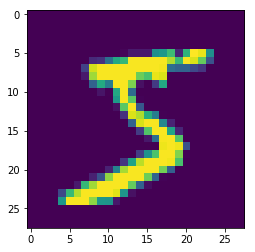

In [9]:
image_side_length = int(np.sqrt(len(x_data[0])))
for i in range(1):
    plt.imshow(x_data_normalized[i].reshape(image_side_length, image_side_length))
    plt.show()

In [94]:
def hinge_loss(pred, y_one_hot):
    correct_class = np.argmax(y_one_hot)
    value_correct_class = pred[correct_class]
    loss = np.maximum(0, pred - value_correct_class + 1)
    loss[correct_class] = 0
    return np.sum(loss)


class LinearClassifier():
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(output_size, input_size)

    def eval(self, inputs, overwrite_weights=None):
        active_weights = self.weights
        if overwrite_weights is not None:
            active_weights = overwrite_weights
        return np.matmul(active_weights, inputs)        

    def outputs_to_probabilities(self, outputs):
        squashed_result = outputs / np.amax(outputs)
        unnormal_probabilities = np.exp(squashed_result)
        if unnormal_probabilities[unnormal_probabilities == np.inf].any():
            raise Exception('There are infinity values in result after exponentiation. Weights might be initialized to high. Value is {}'
                            .format(unnormal_probabilities))
        probabilities = unnormal_probabilities / sum(unnormal_probabilities)
        return probabilities
    
    def batch_eval(self, inputs, overwrite_weights=None):
        return [self.eval(i, overwrite_weights=overwrite_weights) for i in inputs]

    def loss(self, output, one_hot_target, loss_func=hinge_loss):        
        return loss_func(output, one_hot_target)
    
    def cost_vrt(self, outputs, one_hot_targets, loss_func=hinge_loss):
        cost = 0
        for i, t in zip(outputs, one_hot_targets):
            cost += self.loss(i, t, loss_func=loss_func)
        return cost / len(outputs)
    
    def gradient_vrt(self, inputs, one_hot_targets, dx=0.0001, batch_size=None):        
        data = zip(inputs, one_hot_targets)
        data_length = batch_size if batch_size else len(inputs)
        if batch_size:
            data = random.sample(list(data), batch_size)
        weight_mat_shape = self.weights.shape
        weight_mat_size = np.size(self.weights)
        total_gradient = np.zeros(weight_mat_shape)
        cnt = 0
        for sample_input, target in data:
            sample_gradient = []
            print('{}/{} - '.format(cnt, data_length), end='\r')
            cnt += 1
            for i in range(weight_mat_size):
                # if i % 1000 == 0:
                #     print('{} / {}'.format(i, weight_mat_size), end='\r')
                self.weights = self.weights.reshape(-1)
                self.weights[i] += dx
                self.weights = self.weights.reshape(weight_mat_shape)              
                nudged_out = self.eval(sample_input)
                self.weights = self.weights.reshape(-1)
                self.weights[i] -= dx
                self.weights = self.weights.reshape(weight_mat_shape)   
                
                out = self.eval(sample_input)
                
                sample_gradient.append((self.loss(nudged_out, one_hot_targets) - self.loss(out, one_hot_targets)) / dx)
                #if self.loss(nudged_out, one_hot_targets) - self.loss(out, one_hot_targets) / dx > 1:
                    # print('n_out', nudged_out)
                    # print('out', out)
                    #print('nudge_mat_max', np.argmax(nudge_weight_mat))
                    #print('diff', self.loss(nudged_out, one_hot_targets) - self.loss(out, one_hot_targets))
                    #print('diff weights', sum(nudged_weight_mat), sum(self.weights))
                    #raise Exception()
            total_gradient += np.reshape(sample_gradient, weight_mat_shape)
        total_gradient /= data_length
        # print('pre noraml total grad', total_gradient)
        # print(np.max(total_gradient)/ np.size(data))
        # raise Exception()
        # print('culp?:', np.take(total_gradient, np.where(total_gradient >= 0.3)))
        # print('culp?:', np.max(total_gradient))
        # print(total_gradient.shape)
        # print(self.weights.shape)
        # raise Exception()
        return total_gradient
        
    def eval_performance(self, inputs, one_hot_targets):
        val_res = []
        for x, y in zip(inputs, one_hot_targets):
            val_res.append(np.argmax(lc.eval(x)) == np.argmax(y))
        correct_classified = int(sum(val_res) / len(val_res) * 100)
        print('{}% Classified correctly'.format(correct_classified))
        
    def train(self, inputs, one_hot_targets, epochs=1, learning_rate=0.01, verbose=False, batch_size=None):
        prev_loss = None
        for ep in range(epochs):
            gradient = self.gradient_vrt(inputs, one_hot_targets, batch_size=batch_size)     
            if verbose:
                clear_output()
                #print('gradient:', gradient)
                print('gradient max val:', np.max(gradient * learning_rate))
                current_loss = self.cost_vrt(self.batch_eval(inputs), one_hot_targets)
                print('loss:', current_loss)
                if prev_loss:
                    print('loss improvment:', prev_loss - current_loss)
                prev_loss = current_loss
                print('weights max', np.max(self.weights))
                print('weights min', np.min(self.weights))
                self.eval_performance(inputs, one_hot_targets)
                print('----------')
            self.weights = self.weights + (gradient * learning_rate)
            

In [95]:
lc = LinearClassifier(x_data_normalized[0].size, y_one_hot[0].size)

In [97]:


def run():
    lc.train(x_data_normalized[:100], y_one_hot[:100], verbose=True, batch_size=None, epochs=20000, learning_rate=0.001)
    
    print(np.argmax(lc.eval(x_data_normalized[0])))
    print(np.argmax(y_one_hot[0]))
    

    

run()

gradient max val: 0.0005741176471417475
loss: 30.28033044397468
weights max 1.1028650425309068
weights min -0.9412469846906562
15% Classified correctly
----------


gradient max val: 0.0005741176470735355
loss: 30.397623984181422
loss improvment: -0.11729354020674165
weights max 1.1033115131192162
weights min -0.9440218082199409
15% Classified correctly
----------


gradient max val: 0.000574117647065009
loss: 30.514917524388167
loss improvment: -0.1172935402067452
weights max 1.1037579837074631
weights min -0.9467966317492824
15% Classified correctly
----------


KeyboardInterrupt: 

In [218]:
class RandGen():
    def __init__(self, seed=0):
        self.seed = seed
        self.previous_rand = seed
        self.position = 0
        self.a = 156316
        self.b = 46542
        self.m = 45755456
        
    def generate(self):
        rand = (self.a * self.previous_rand + self.b) % self.m
        print(np.power(10, len(str(self.m))))
        rand /= np.power(10, len(str(self.m)) - 2)
        self.previous_rand = rand
        self.position += 1    
        return rand
    
rg = RandGen()

In [282]:
print(np.power(10, 10))

for i in range(2):
    print(rg.generate())
    
rg.position
rg.previous_rand

1410065408
100000000
0.05516520403373776
100000000
0.05516520403373776


0.05516520403373776

In [62]:
a = np.array([[1,2,0]])
b = np.array([-0,2,1])
print(a.shape)
print(b.shape)
np.matmul(a, b)

(1, 3)
(3,)
